# Plot CK-UCB Experiment Results

This notebook loads a pickle file containing experiment results and plots cumulative regret with confidence intervals.

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

from experiments.utils import stats

In [9]:

# Path to your results file
pickle_path = 'experiments/runs/ckucb_gap_vs_final_regret/20250715_071453/gap_results.pkl'  # <-- change this to your actual file path

try:
    with open(pickle_path, 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    print(f"File {pickle_path} not found.")

results.keys()  # Display the keys in the results dictionary

dict_keys(['gaps', 'mean_final', 'ci_final', 'time_series'])

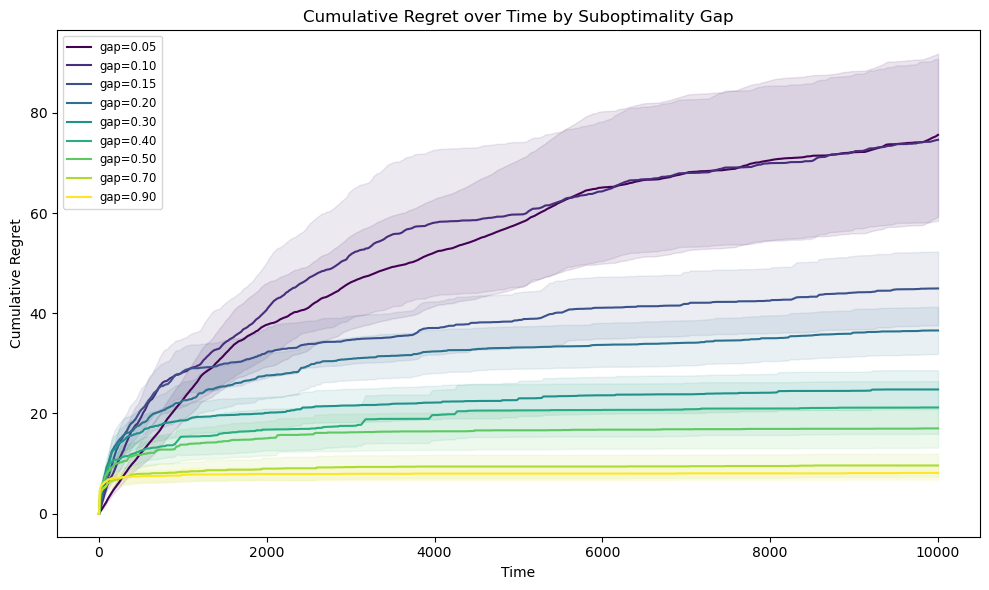

In [10]:
# ================= Plot 3: time-series for each gap =================
gaps = results['gaps']
all_time_series = results['time_series']

plt.figure(figsize=(10,6))

# Create a colormap for monotonic colors based on gap values
colors = plt.cm.viridis(np.linspace(0, 1, len(gaps)))

for i, (gap, ts_runs) in enumerate(zip(gaps, all_time_series)):
    avg, ub, lb = stats(ts_runs)
    # normalize by gap
    T = len(avg)
    plt.plot(np.arange(1, T+1), avg, label=f'gap={gap:.2f}', color=colors[i])
    plt.fill_between(np.arange(1, T+1), lb, ub, alpha=0.1, color=colors[i])

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time by Suboptimality Gap')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


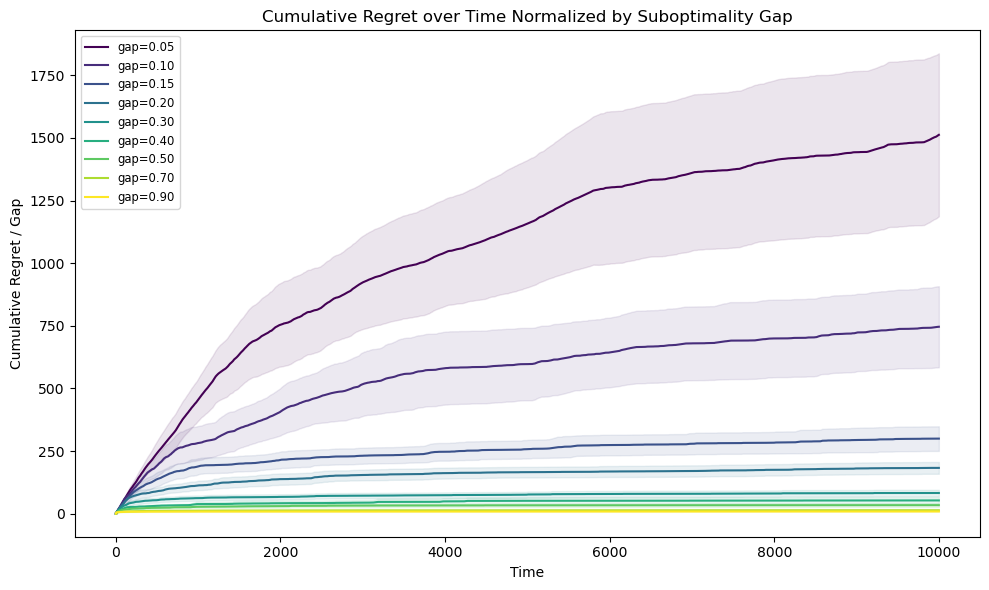

In [11]:
# ================= Plot 4: time-series for each gap =================
gaps = results['gaps']
all_time_series = results['time_series']

plt.figure(figsize=(10,6))

# Create a colormap for monotonic colors based on gap values
colors = plt.cm.viridis(np.linspace(0, 1, len(gaps)))

for i, (gap, ts_runs) in enumerate(zip(gaps, all_time_series)):
    avg, ub, lb = stats(ts_runs)
    # normalize by gap
    avg /= gap
    ub /= gap
    lb /= gap
    T = len(avg)
    plt.plot(np.arange(1, T+1), avg, label=f'gap={gap:.2f}', color=colors[i])
    plt.fill_between(np.arange(1, T+1), lb, ub, alpha=0.1, color=colors[i])

plt.xlabel('Time')
plt.ylabel('Cumulative Regret / Gap')
plt.title('Cumulative Regret over Time Normalized by Suboptimality Gap')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [12]:
out = os.path.join(os.path.dirname(pickle_path), 'gap_vs_final_regret_normalized.png')
plt.savefig(out)

<Figure size 640x480 with 0 Axes>

=== gap = 0.30 → log‐fit ===
A = 3.011 ± 0.004
B = -2.675 ± 0.030

=== gap = 0.05 → sqrt‐fit ===
C = 0.804 ± 0.001
D = -0.521 ± 0.081


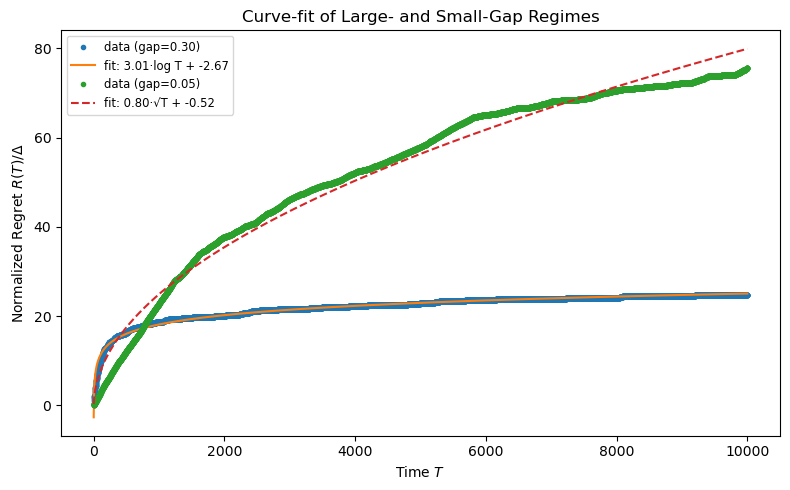

=== Large-gap series (gap > 0.2) ===
log-fit   RSS=1301.4, MSE=0.130, R²=0.9858, AIC=-20387.1, BIC=-20372.7
sqrt-fit  RSS=12283794.8, MSE=1228.379, R²=-133.2150, AIC=71138.5, BIC=71152.9

=== Small-gap series (gap ≤ 0.2) ===
log-fit   RSS=12293233.8, MSE=1229.323, R²=-2.3528, AIC=71146.2, BIC=71160.6
sqrt-fit  RSS=73162.6, MSE=7.316, R²=0.9800, AIC=19905.0, BIC=19919.4


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ——— 1. Model functions ———
def f_log(T, A, B):
    """A·log(T) + B"""
    return A * np.log(T) + B

def f_sqrt(T, C, D):
    """C·sqrt(T) + D"""
    return C * np.sqrt(T) + D

# ——— 2. Build normalized‑avg lookup ———
# (gap → avg_normalized_regret over runs)
unnorm_avg = {}
for gap, ts_runs in zip(gaps, all_time_series):
    avg, ub, lb = stats(ts_runs)
    unnorm_avg[gap] = avg

# ——— 3. Select two representative gaps above/below 0.2 ———
large_gap = 0.3 #next(g for g in gaps if g > 0.2)  # e.g. 0.3
small_gap = 0.05 #next(g for g in gaps if g < 0.2)  # e.g. 0.05

# ——— 4. Prepare data for fitting ———
T = len(unnorm_avg[large_gap])
times = np.arange(1, T+1)

y_large = unnorm_avg[large_gap]
y_small = unnorm_avg[small_gap]

# ——— 5. Perform the fits ———
# 5a) Log‐fit on large‐gap
p0_log = [1.0, 0.0]
popt_log, pcov_log = curve_fit(f_log, times, y_large, p0=p0_log)
perr_log = np.sqrt(np.diag(pcov_log))
A, B = popt_log

# 5b) Sqrt‐fit on small‐gap
p0_sqrt = [1.0, 0.0]
popt_sqrt, pcov_sqrt = curve_fit(f_sqrt, times, y_small, p0=p0_sqrt)
perr_sqrt = np.sqrt(np.diag(pcov_sqrt))
C, D = popt_sqrt

# ——— 6. Print out results ———
print(f"=== gap = {large_gap:.2f} → log‐fit ===")
print(f"A = {A:.3f} ± {perr_log[0]:.3f}")
print(f"B = {B:.3f} ± {perr_log[1]:.3f}\n")

print(f"=== gap = {small_gap:.2f} → sqrt‐fit ===")
print(f"C = {C:.3f} ± {perr_sqrt[0]:.3f}")
print(f"D = {D:.3f} ± {perr_sqrt[1]:.3f}")

# ——— 7. Overlay plot ———
plt.figure(figsize=(8,5))
plt.plot(times, y_large, '.', label=f"data (gap={large_gap:.2f})")
plt.plot(times, f_log(times, *popt_log), '-', 
         label=f"fit: {A:.2f}·log T + {B:.2f}")

plt.plot(times, y_small, '.', label=f"data (gap={small_gap:.2f})")
plt.plot(times, f_sqrt(times, *popt_sqrt), '--', 
         label=f"fit: {C:.2f}·√T + {D:.2f}")

plt.xlabel('Time $T$')
plt.ylabel('Normalized Regret $R(T)/\\Delta$')
plt.title('Curve‐fit of Large‐ and Small‐Gap Regimes')
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()


# assume `times`, `y_large`, `y_small`, popt_log, popt_sqrt are already defined

def compute_metrics(y, y_pred, k):
    """Return RSS, MSE, R2, AIC, BIC for a fit of k parameters."""
    n = len(y)
    resid = y - y_pred
    rss = np.sum(resid**2)
    mse = rss / n
    tss = np.sum((y - np.mean(y))**2)
    r2  = 1 - rss/tss
    aic = 2*k + n * np.log(rss/n)
    bic = k * np.log(n) + n * np.log(rss/n)
    return rss, mse, r2, aic, bic

# 1) Evaluate on the large-gap series using both models:
yL = y_large
pred_log  = f_log(times, *popt_log)
pred_sqrt = f_sqrt(times, *popt_sqrt)

print("=== Large-gap series (gap > 0.2) ===")
for name, pred in [("log-fit", pred_log), ("sqrt-fit", pred_sqrt)]:
    rss, mse, r2, aic, bic = compute_metrics(yL, pred, k=2)
    print(f"{name:8s}  RSS={rss:.1f}, MSE={mse:.3f}, R²={r2:.4f}, AIC={aic:.1f}, BIC={bic:.1f}")

# 2) Same for the small-gap series:
yS = y_small
print("\n=== Small-gap series (gap ≤ 0.2) ===")
for name, pred in [("log-fit", f_log(times, *popt_log)), 
                   ("sqrt-fit", f_sqrt(times, *popt_sqrt))]:
    rss, mse, r2, aic, bic = compute_metrics(yS, pred, k=2)
    print(f"{name:8s}  RSS={rss:.1f}, MSE={mse:.3f}, R²={r2:.4f}, AIC={aic:.1f}, BIC={bic:.1f}")


=== Normalized Regret Analysis ===
Large gap = 0.30 → log‐fit on R(T)/Δ ===
A = 10.038 ± 0.012
B = -8.916 ± 0.100
Fit: R(T)/Δ = 10.04·log(T) + -8.92

=== Small gap = 0.10 → sqrt‐fit on R(T)/Δ ===
C = 7.166 ± 0.014
D = 76.963 ± 1.014
Fit: R(T)/Δ = 7.17·√T + 76.96


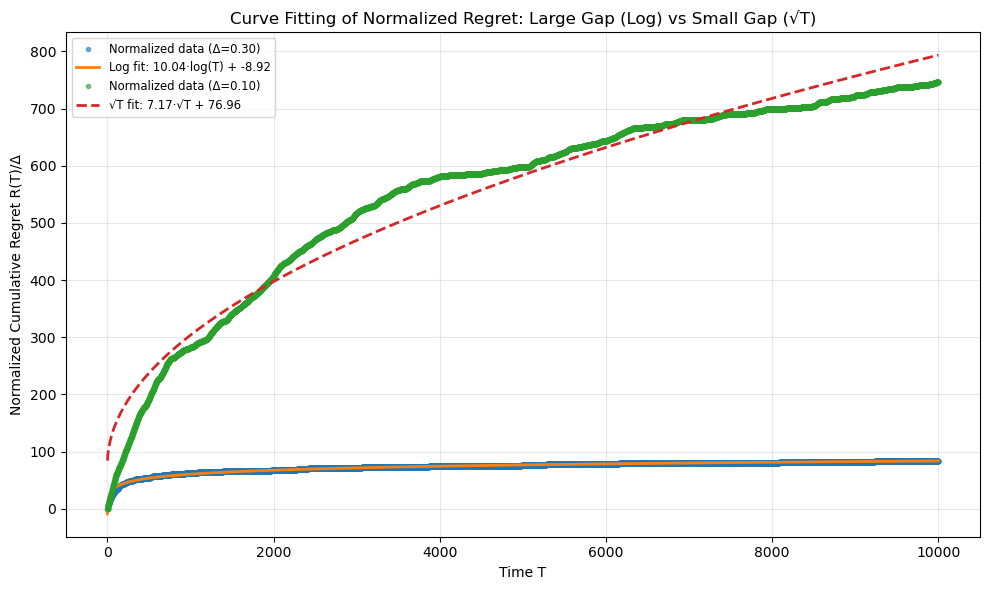

=== Large-gap series (gap > 0.2) ===
log-fit   RSS=26964888.5, MSE=2696.489, R²=-293.6232, AIC=79001.1, BIC=79015.5
sqrt-fit  RSS=3113576294.2, MSE=311357.629, R²=-34018.4977, AIC=126491.0, BIC=126505.4

=== Small-gap series (gap ≤ 0.2) ===
log-fit   RSS=3855324.3, MSE=385.532, R²=-0.2997, AIC=59550.3, BIC=59564.7
sqrt-fit  RSS=2723815611.7, MSE=272381.561, R²=-917.2796, AIC=125153.6, BIC=125168.0


In [14]:
from scipy.optimize import curve_fit

# ——— 1. Model functions ———
def f_log(T, A, B):
    """A·log(T) + B"""
    return A * np.log(T) + B

def f_sqrt(T, C, D):
    """C·sqrt(T) + D"""
    return C * np.sqrt(T) + D

# ——— 2. Build normalized‑avg lookup ———
# (gap → avg_normalized_regret over runs)
unnorm_avg = {}
for gap, ts_runs in zip(gaps, all_time_series):
    avg, ub, lb = stats(ts_runs)
    unnorm_avg[gap] = avg / gap

# ——— 3. Select two representative gaps above/below 0.2 ———
large_gap = 0.3  # Large gap for log regime
small_gap = 0.1  # Small gap for sqrt regime

# ——— 4. Prepare normalized data for fitting ———
T = len(unnorm_avg[large_gap])
times = np.arange(1, T+1)

y_large_norm = unnorm_avg[large_gap]
y_small_norm = unnorm_avg[small_gap]

# ——— 5. Perform the fits on normalized data ———
# 5a) Log‐fit on large‐gap normalized regret
p0_log = [1.0, 0.0]
popt_log, pcov_log = curve_fit(f_log, times, y_large_norm, p0=p0_log)
perr_log = np.sqrt(np.diag(pcov_log))
A, B = popt_log

# 5b) Sqrt‐fit on small‐gap normalized regret
p0_sqrt = [1.0, 0.0]
popt_sqrt, pcov_sqrt = curve_fit(f_sqrt, times, y_small_norm, p0=p0_sqrt)
perr_sqrt = np.sqrt(np.diag(pcov_sqrt))
C, D = popt_sqrt

# ——— 6. Print out results for normalized regret ———
print(f"=== Normalized Regret Analysis ===")
print(f"Large gap = {large_gap:.2f} → log‐fit on R(T)/Δ ===")
print(f"A = {A:.3f} ± {perr_log[0]:.3f}")
print(f"B = {B:.3f} ± {perr_log[1]:.3f}")
print(f"Fit: R(T)/Δ = {A:.2f}·log(T) + {B:.2f}\n")

print(f"=== Small gap = {small_gap:.2f} → sqrt‐fit on R(T)/Δ ===")
print(f"C = {C:.3f} ± {perr_sqrt[0]:.3f}")
print(f"D = {D:.3f} ± {perr_sqrt[1]:.3f}")
print(f"Fit: R(T)/Δ = {C:.2f}·√T + {D:.2f}")

# ——— 7. Overlay plot for normalized regret ———
plt.figure(figsize=(10,6))
plt.plot(times, y_large_norm, '.', alpha=0.6, label=f"Normalized data (Δ={large_gap:.2f})")
plt.plot(times, f_log(times, *popt_log), '-', linewidth=2,
         label=f"Log fit: {A:.2f}·log(T) + {B:.2f}")

plt.plot(times, y_small_norm, '.', alpha=0.6, label=f"Normalized data (Δ={small_gap:.2f})")
plt.plot(times, f_sqrt(times, *popt_sqrt), '--', linewidth=2,
         label=f"√T fit: {C:.2f}·√T + {D:.2f}")

plt.xlabel('Time T')
plt.ylabel('Normalized Cumulative Regret R(T)/Δ')
plt.title('Curve Fitting of Normalized Regret: Large Gap (Log) vs Small Gap (√T)')
plt.legend(fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 1) Evaluate on the large-gap series using both models:
yL = y_large
pred_log  = f_log(times, *popt_log)
pred_sqrt = f_sqrt(times, *popt_sqrt)

print("=== Large-gap series (gap > 0.2) ===")
for name, pred in [("log-fit", pred_log), ("sqrt-fit", pred_sqrt)]:
    rss, mse, r2, aic, bic = compute_metrics(yL, pred, k=2)
    print(f"{name:8s}  RSS={rss:.1f}, MSE={mse:.3f}, R²={r2:.4f}, AIC={aic:.1f}, BIC={bic:.1f}")

# 2) Same for the small-gap series:
yS = y_small
print("\n=== Small-gap series (gap ≤ 0.2) ===")
for name, pred in [("log-fit", f_log(times, *popt_log)), 
                   ("sqrt-fit", f_sqrt(times, *popt_sqrt))]:
    rss, mse, r2, aic, bic = compute_metrics(yS, pred, k=2)
    print(f"{name:8s}  RSS={rss:.1f}, MSE={mse:.3f}, R²={r2:.4f}, AIC={aic:.1f}, BIC={bic:.1f}")
